In [14]:
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号#有中文出现的情况，需要u'内容'

import seaborn as sns
%matplotlib inline

In [4]:
# 从硬盘读取数据进入内存

train_df = pd.read_excel("../data/train2.xlsx", engine='openpyxl', sheet_name='training')
train_df = train_df.iloc[:, 1:1500]

In [5]:
# features = train_df.corr().columns[train_df.corr()['pIC50'].abs() > .3]
# features = features.drop('pIC50')
#
# corr = train_df.corr()[train_df.corr()['pIC50'].abs() > .3]['pIC50'].drop('pIC50')
# corr = corr.sort_values(ascending=True)
# fea_idx = corr.index
#
# for i in range(len(corr)):
#     first,sec = corr.index[i],corr.iloc[i]
#     print("%2d. %-*s %f" % (i + 1, 30, first, sec))

 1. hmin                           -0.426365
 2. C1SP2                          -0.406929
 3. ATSc3                          -0.351859
 4. ETA_Epsilon_4                  -0.351553
 5. mindO                          -0.335274
 6. maxdO                          -0.328900
 7. SaaN                           -0.328658
 8. naaN                           -0.327903
 9. maxaaN                         -0.323642
10. minHssNH                       -0.322588
11. maxHssNH                       -0.320859
12. minaaN                         -0.320223
13. BCUTc-1l                       -0.319257
14. ETA_Beta                       0.307245
15. ETA_Beta_s                     0.310525
16. SHsOH                          0.314664
17. C1SP3                          0.317207
18. nBondsS2                       0.317803
19. ATSc4                          0.318528
20. MW                             0.318592
21. minHBint10                     0.320568
22. VP-6                           0.321705
23. SsssN          

In [6]:
# corr = corr.to_frame()
# fig, ax = plt.subplots()
# im = ax.imshow(corr)
#
# # We want to show all ticks...
# ax.set_xticks(np.arange(len(corr.index)))
# ax.set_yticks(np.arange(len(['pIC50'])))
# # ... and label them with the respective list entries
# ax.set_xticklabels(corr.index)
# ax.set_yticklabels(['pIC50'])
#
# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
#
# # Loop over data dimensions and create text annotations.
# for i in range(len(corr.index)):
#     for j in range(len('pIC50')):
#         text = ax.text(j, i, corr[i, j],
#                        ha="center", va="center", color="w")
#
# ax.set_title("PCCs")
# fig.tight_layout()

In [31]:
    # 先用皮尔逊系数粗略的选择出相关性系数的绝对值大于0.3的属性列，这样不需要训练过多不重要的属性列
    # 可以这么做而且不会破坏实验的控制变量原则，因为根据皮尔逊相关系数选择出的重要性排名前10的属性列
    # 它们与要预测的属性列的皮尔逊相关系数均大于0.3，可以当成步骤1中也进行了同样的取相关系数为0.3的操作
    corr = train_df.corr()[train_df.corr()['pIC50'].abs() > .3]['pIC50']
    features = train_df.corr().columns[train_df.corr()['pIC50'].abs() > .3]
    features = features.drop('pIC50')

# 使用随机森林模型进行拟合的过程
    X_train = train_df[features]
    # X_train = train_df
    y_train = train_df['pIC50']
    feat_labels = X_train.columns

    rf = RandomForestRegressor(n_estimators=1000, max_depth=None)
    rf_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('standardize', StandardScaler()), ('rf', rf)])
    rf_pipe.fit(X_train, y_train)

    # 根据随机森林模型的拟合结果选择特征
    rf = rf_pipe.__getitem__('rf')
    importance = rf.feature_importances_

    # np.argsort()返回待排序集合从下到大的索引值，[::-1]实现倒序，即最终imp_result内保存的是从大到小的索引值
    imp_result = np.argsort(importance)[::-1][:20]
    print(imp_result)
    # 按重要性从高到低输出属性列名和其重要性
    important_feature = list()
    for i in range(len(imp_result)):
        important_feature.append(feat_labels[imp_result[i]])
        print("%2d. %-*s %f" % (i + 1, 30, feat_labels[imp_result[i]], importance[imp_result[i]]))

[85 74 20  7 63 66 14 60 73 86 64 59 95 15 50 39  8 22 58 72]
 1. MDEC-23                        0.213423
 2. LipoaffinityIndex              0.050112
 3. C1SP2                          0.046506
 4. ATSc3                          0.041540
 5. minsssN                        0.041525
 6. maxHsOH                        0.040628
 7. BCUTc-1l                       0.032125
 8. minHsOH                        0.031686
 9. hmin                           0.028587
10. MLFER_A                        0.027552
11. minsOH                         0.027280
12. minHBint10                     0.021323
13. XLogP                          0.017318
14. BCUTp-1h                       0.016641
15. SHsOH                          0.016473
16. CrippenLogP                    0.015712
17. ATSc4                          0.015530
18. C3SP2                          0.013201
19. SsOH                           0.013054
20. maxdO                          0.011947


ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of ticklabels (98).

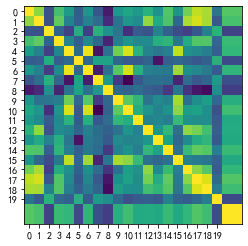

In [29]:
select_df = train_df[important_feature]
features = select_df.corr()

fig, ax = plt.subplots()
im = ax.imshow(features)
# We want to show all ticks...
ax.set_xticks(np.arange(20))
ax.set_yticks(np.arange(20))
# ... and label them with the respective list entries
ax.set_xticklabels(corr.index)
ax.set_yticklabels(['pIC50'])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(corr.index)):
    for j in range(len('pIC50')):
        text = ax.text(j, i, corr[i, j],
                       ha="center", va="center", color="w")

ax.set_title("PCCs")
fig.tight_layout()

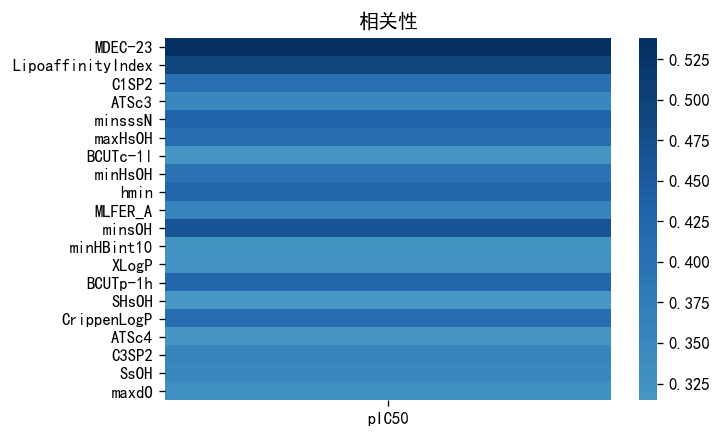

In [48]:
# ip = important_feature.append('pIC50')
# important_feature.append('pIC50')
select_df = train_df[important_feature]
features = select_df.corr()
features = features['pIC50']

# features.update(features.select_dtypes(include=[np.number]).abs())
data = np.asarray(features).reshape(-1,1)
data = np.abs(data)
plt.figure(dpi=120)

# sns.heatmap(data=data,#矩阵数据集，数据的index和columns分别为heatmap的y轴方向和x轴方向标签
#          )
ax = sns.heatmap(data[0:-1,:],cmap = 'RdBu', center=0,cbar = True, square = False,
                 xticklabels =['pIC50'],yticklabels=important_feature[:-1])
plt.title('相关性')
plt.savefig("q1_correction.png")